Things to do here:
- show the difference between kappa=1 and kappa=2
- look at the error estimates from one of the relevant papers. how does the estimate vary with distance from a singularity? with the order of the singularity? what if only the derivatives are singular?
- maybe stage2 refinement should be modified near a singularity?

Fault tips: 
- Identify or specify singularities and then make sure that the QBX and quadrature account for the singularities. This would be helpful for avoiding the need to have the sigmoid transition.
- *Would it be useful to use an interpolation that includes the end points so that I can easily make sure that slip goes to zero at a fault tip?* --> I should test this!

In [1]:
from config import setup, import_and_display_fnc

setup()

In [134]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from common import (
    gauss_rule,
    qbx_matrix2,
    single_layer_matrix,
    double_layer_matrix,
    adjoint_double_layer_matrix,
    hypersingular_matrix,
    stage1_refine,
    qbx_panel_setup,
    stage2_refine,
    pts_grid,
)

In [148]:
import quadpy

def clencurt(n1):
    """Computes the Clenshaw Curtis quadrature nodes and weights"""
    C = quadpy.c1.clenshaw_curtis(n1)
    return (C.points, C.weights)

In [205]:
log(np.sqrt(2) * 0.001) / log(0.03125)

1.8931568569324173

[-0.00098989 -0.00556183 -0.01318359 -0.01757813 -0.0234375  -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.0312

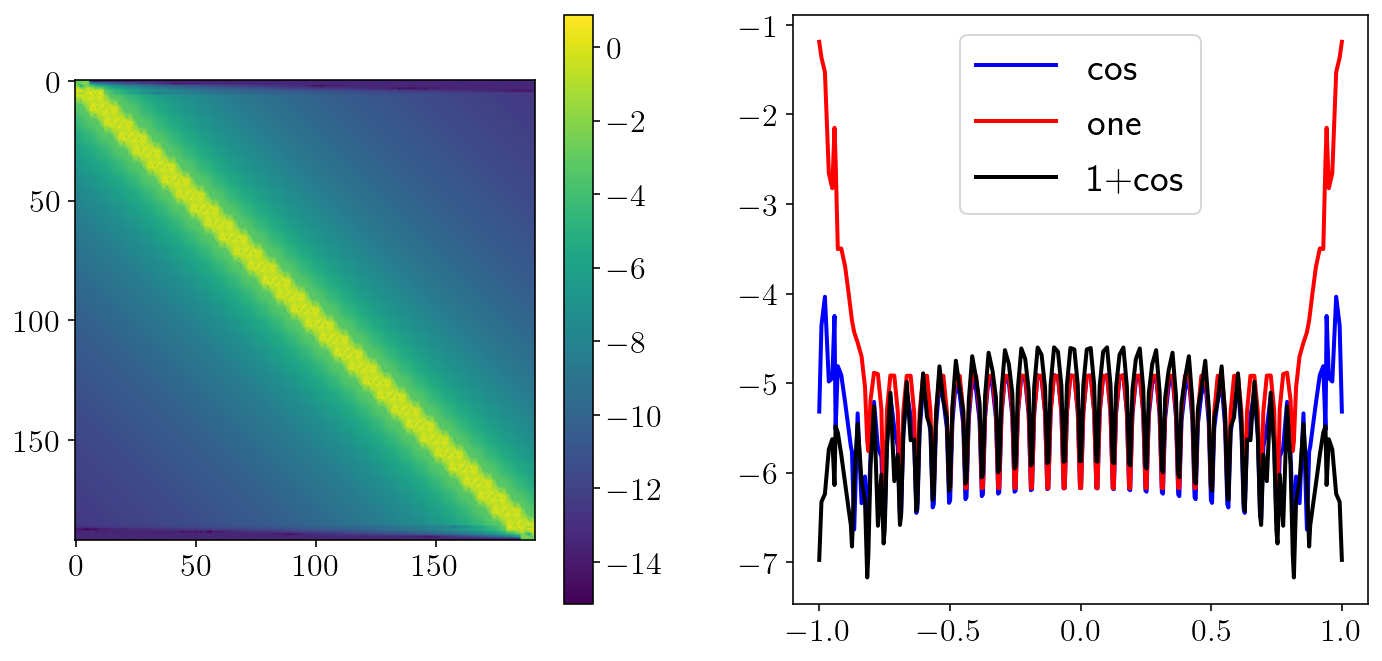

In [206]:
panel_width = 0.125
nq = 6
t = sp.var("t")
fault, = stage1_refine([(t, t * 0, t)], gauss_rule(nq), control_points=[(0, 0, 1.0, panel_width)])
fault_expansions, = qbx_panel_setup(
    [fault], directions=[1], mult=0.5, singularities=np.array([[0,-1], [0,1]])
)
print(fault_expansions.pts[:,0])

print(fault.n_panels, fault.n_pts)
K = hypersingular_matrix
#K = double_layer_matrix
#K = single_layer_matrix
M = qbx_matrix2(K, fault, fault.pts, fault_expansions, p=4)
M2 = qbx_matrix2(K, fault, fault.pts, fault_expansions, p=5)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.log10(np.abs((M - M2) / M))[:,0,:])
plt.colorbar()
plt.subplot(1,2,2)
slip = np.cos(np.pi * 0.5 * fault.pts[:,1])
slip_err = M.dot(slip) - M2.dot(slip)
plt.plot(fault.pts[:,1], np.log10(np.abs(slip_err[:,0])), 'b-', label='cos')

y = fault.pts[:,1]

slip = np.ones_like(fault.pts[:,1])
slip_err = M.dot(slip) - M2.dot(slip)
plt.plot(fault.pts[:,1], np.log10(np.abs(slip_err[:,0])), 'r-', label='one')

slip = 1 + np.cos(np.pi * fault.pts[:,1])
slip_err = M.dot(slip) - M2.dot(slip)
plt.plot(fault.pts[:,1], np.log10(np.abs(slip_err[:,0])), 'k-', label='1+cos')

plt.legend()
plt.tight_layout()
plt.show()

[-0.00098989 -0.00556183 -0.01318359 -0.01757813 -0.0234375  -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.03125    -0.03125    -0.03125    -0.03125    -0.03125
 -0.03125    -0.0312

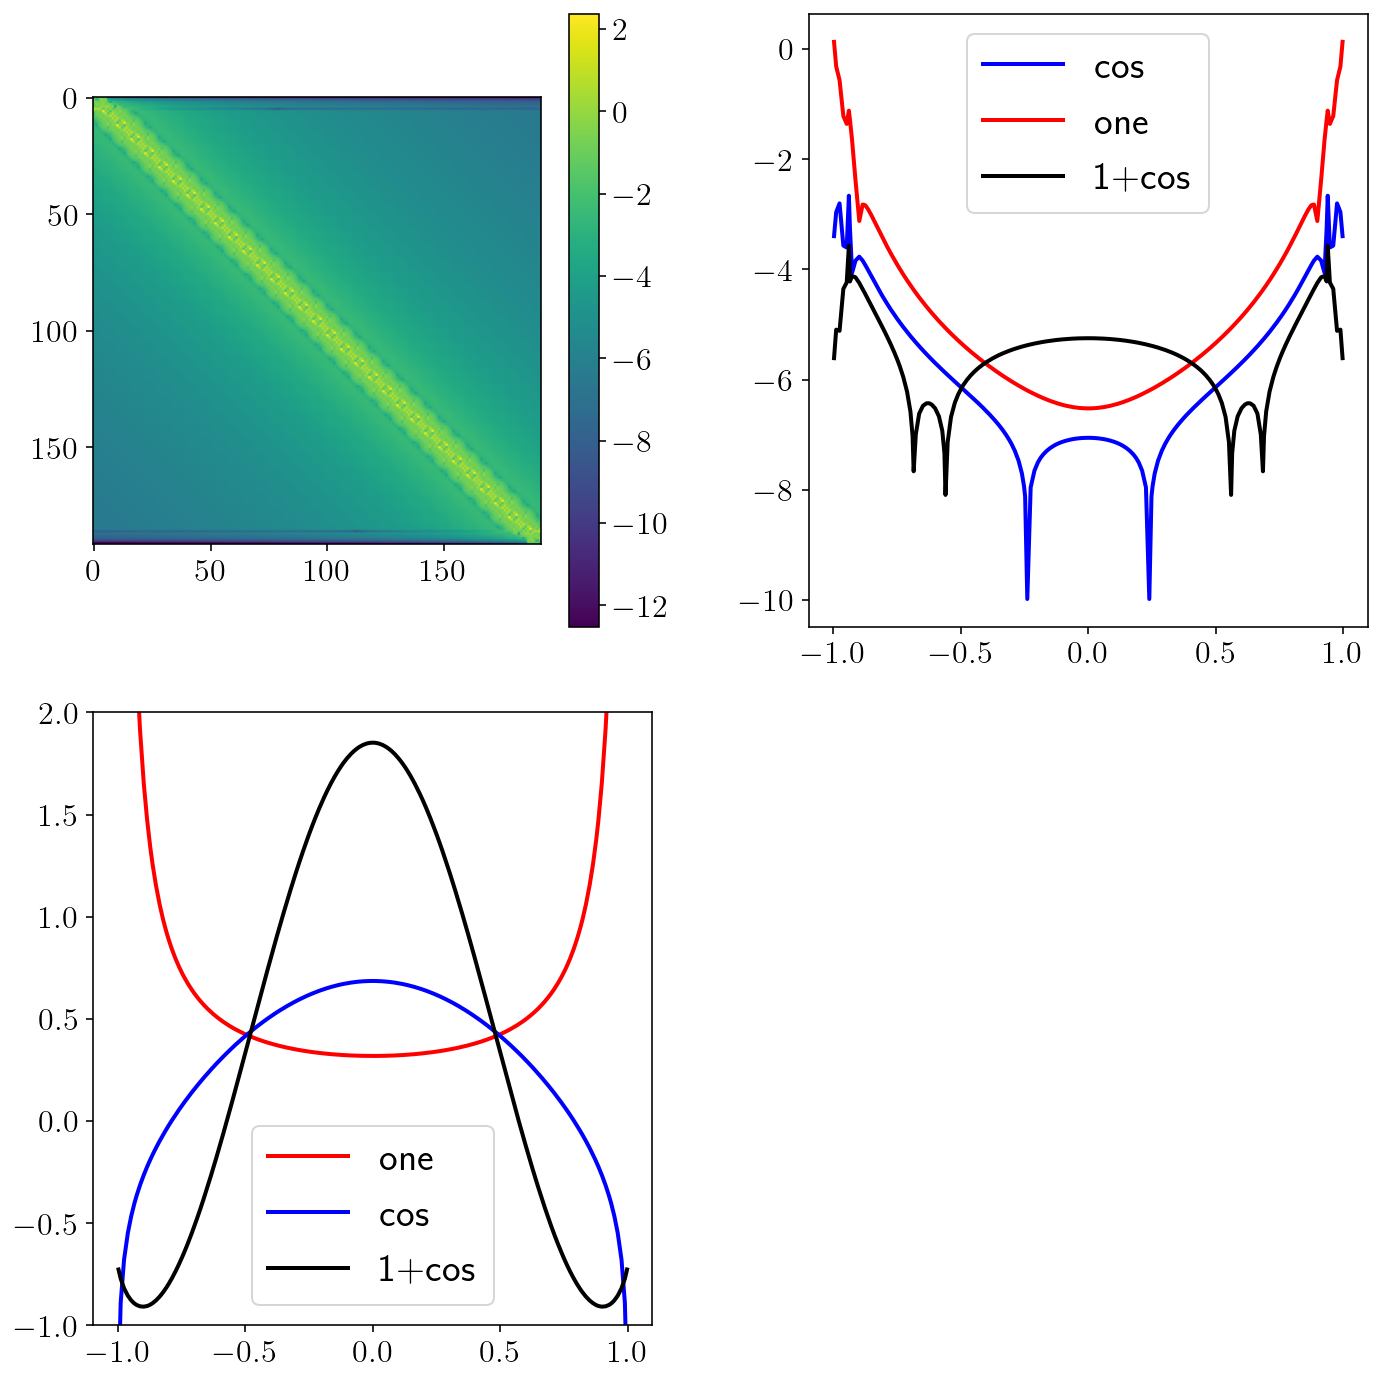

In [207]:
panel_width = 0.125
nq = 6
t = sp.var("t")
fault, = stage1_refine([(t, t * 0, t)], gauss_rule(nq), control_points=[(0, 0, 1.0, panel_width)])
fault_expansions, = qbx_panel_setup(
    [fault], directions=[1], mult=0.5, singularities=np.array([[0,-1], [0,1]])
)
print(fault_expansions.pts[:,0])

print(fault.n_panels, fault.n_pts)
K = hypersingular_matrix
#K = double_layer_matrix
#K = single_layer_matrix
M = qbx_matrix2(K, fault, fault.pts, fault_expansions, p=4, kappa=10)
M2 = qbx_matrix2(K, fault, fault.pts, fault_expansions, p=5, kappa=10)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(np.log10(np.abs((M - M2) / M))[:,0,:])
plt.colorbar()
plt.subplot(2,2,2)
slip_cos = np.cos(np.pi * 0.5 * fault.pts[:,1])
slip_err = M.dot(slip_cos) - M2.dot(slip_cos)
plt.plot(fault.pts[:,1], np.log10(np.abs(slip_err[:,0])), 'b-', label='cos')

y = fault.pts[:,1]

slip_ones = np.ones_like(fault.pts[:,1])
slip_err = M.dot(slip_ones) - M2.dot(slip_ones)
plt.plot(fault.pts[:,1], np.log10(np.abs(slip_err[:,0])), 'r-', label='one')

slip_1cos = 1 + np.cos(np.pi * fault.pts[:,1])
slip_err = M.dot(slip_1cos) - M2.dot(slip_1cos)
plt.plot(fault.pts[:,1], np.log10(np.abs(slip_err[:,0])), 'k-', label='1+cos')
plt.legend()

plt.subplot(2,2,3)
plt.plot(y, M2.dot(slip_ones)[:,0], 'r-', label='one')
plt.plot(y, M2.dot(slip_cos)[:,0], 'b-', label='cos')
plt.plot(y, M2.dot(slip_1cos)[:,0], 'k-', label='1+cos')
plt.ylim([-1, 2])
plt.legend()

plt.tight_layout()
plt.show()

## Convergence with r

In [289]:
panel_width = 0.75
nq = 16
t = sp.var("t")
fault, = stage1_refine([(t, t * 0, t)], gauss_rule(nq), control_points=[(0, 0, 1.0, panel_width)])
fault_expansions, = qbx_panel_setup(
    [fault], directions=[1], mult=0.5, singularities=np.array([[0,-1], [0,1]])
)
#print(fault_expansions.pts[:,0])

print(fault.n_panels, fault.n_pts)
K = hypersingular_matrix
#K = double_layer_matrix
#K = single_layer_matrix
Ms = []

M2 = qbx_matrix2(K, fault, fault.pts, fault_expansions, p=20, kappa=3)

Ms = []
for p in range(4, 20, 2):
    M = qbx_matrix2(K, fault, fault.pts, fault_expansions, p=p, kappa=3)
    Ms.append(M)

16 96


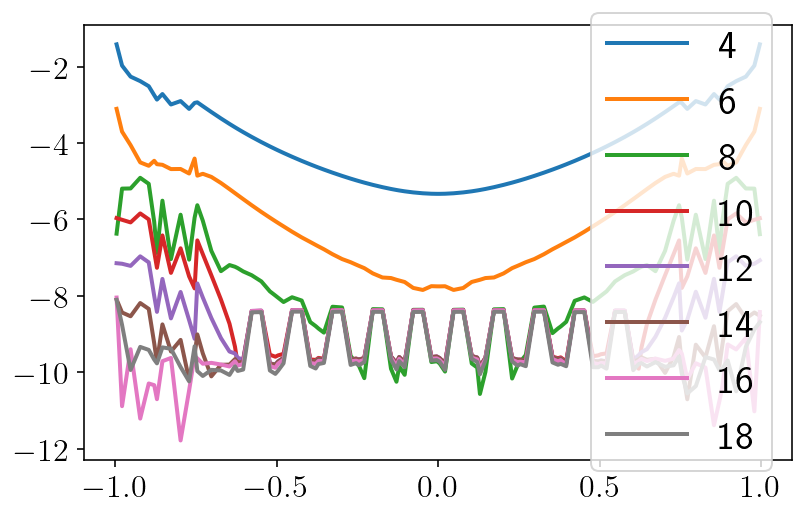

In [290]:
slip_errs = []
svs = []
for i in range(len(Ms)):
    slip = np.ones_like(fault.pts[:,1])
    #slip = np.cos(0.5 * np.pi * fault.pts[:,1])
    #slip = 0.5 + 0.5 * np.cos(np.pi * fault.pts[:,1])
    slip_err = Ms[i].dot(slip) - M2.dot(slip)
    svs.append(Ms[i].dot(slip))
    slip_errs.append(slip_err)
    plt.plot(fault.pts[:,1], np.log10(np.abs(slip_err[:,0])), label=str(4 + 2 * i))
#plt.xlim([-1.1, -0.7])
plt.legend(loc='right')
plt.tight_layout()
plt.show()

In [251]:
np.array(svs)[:,-1,0]

array([-1.12555808, -1.12558454, -1.12558423, -1.12558424, -1.12558424,
       -1.12558424, -1.12558424, -1.12558424])

In [252]:
np.array(slip_errs)[:,-1,0]

array([ 2.61528390e-05, -3.06694414e-07,  3.19503646e-09, -2.27798447e-10,
       -2.54154919e-10, -1.35354394e-10, -9.41011713e-11,  8.65481020e-11])

In [235]:
np.array(svs)[:,-1,0]

array([38.03793271, 37.59171763, 37.82555081, 37.78614324, 37.78762512,
       37.7885651 , 37.78830015, 37.78833068])

In [236]:
np.array(slip_errs)[:,-1,0]

array([ 2.49600452e-01, -1.96614626e-01,  3.72185564e-02, -2.18902044e-03,
       -7.07132828e-04,  2.32847728e-04, -3.21013879e-05, -1.57920959e-06])

## What if I use clenshaw-curtis and just set the endpoints to zero?

In [197]:
panel_width = 0.125
nq = 6
t = sp.var("t")
qx, qw = clencurt(nq)
fault, = stage1_refine([(t, t * 0, t)], (qx, qw), control_points=[(0, 0, 1.0, panel_width)])
fault_expansions, = qbx_panel_setup(
    [fault], directions=[1], mult=0.5, singularities=np.array([[0,-1], [0,1]])
)
print(fault_expansions.pts[:,0])

print(fault.n_panels, fault.n_pts)
K = hypersingular_matrix
#K = double_layer_matrix
#K = single_layer_matrix
M = qbx_matrix2(K, fault, fault.pts, fault_expansions, p=8, kappa=10)
M2 = qbx_matrix2(K, fault, fault.pts, fault_expansions, p=9, kappa=10)

[-1.48818408e-05 -6.25705719e-03 -1.97753906e-02 -4.68750000e-02
 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02
 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02
 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02
 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02
 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02
 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02
 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02
 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02
 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02
 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02
 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02
 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02
 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02
 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02 -6.25000000e-02
 -6.25000000e-02 -6.25000

In [198]:
fault.panel_bounds

array([[-1.   , -0.875],
       [-0.875, -0.75 ],
       [-0.75 , -0.625],
       [-0.625, -0.5  ],
       [-0.5  , -0.375],
       [-0.375, -0.25 ],
       [-0.25 , -0.125],
       [-0.125,  0.   ],
       [ 0.   ,  0.125],
       [ 0.125,  0.25 ],
       [ 0.25 ,  0.375],
       [ 0.375,  0.5  ],
       [ 0.5  ,  0.625],
       [ 0.625,  0.75 ],
       [ 0.75 ,  0.875],
       [ 0.875,  1.   ]])

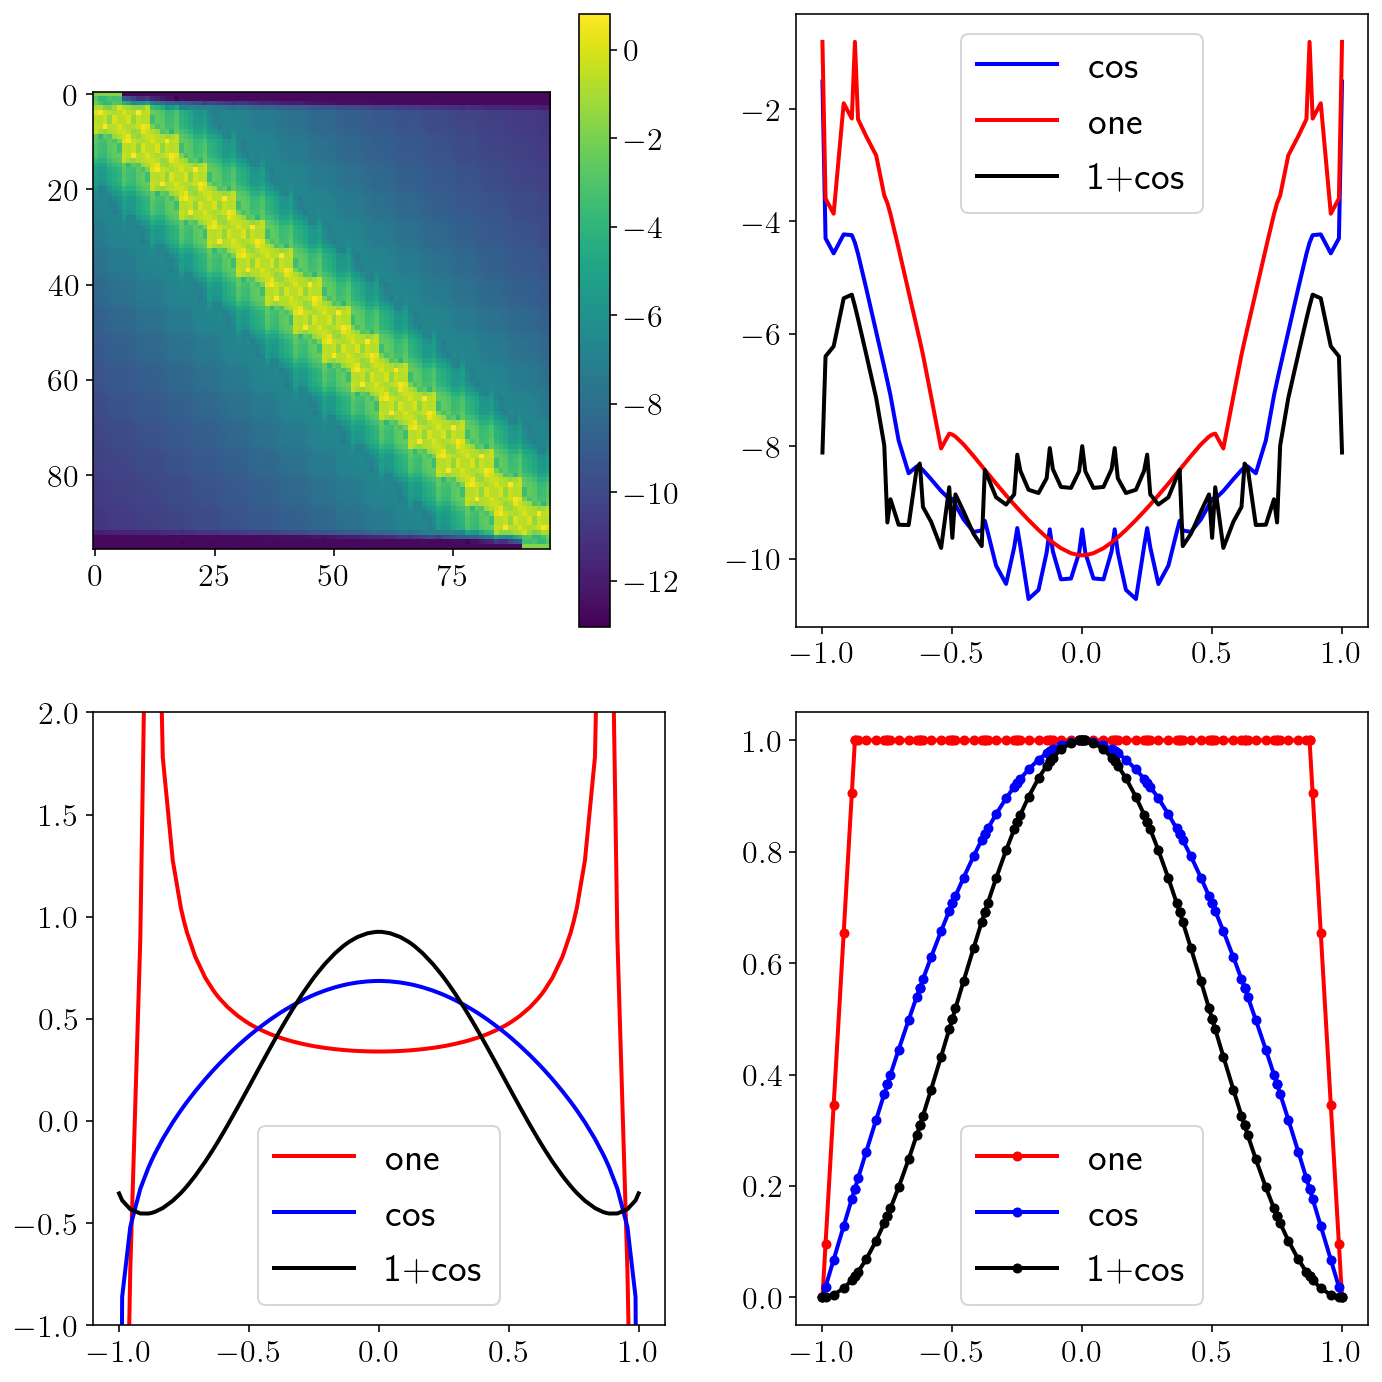

In [199]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(np.log10(np.abs((M - M2) / M))[:,0,:])
plt.colorbar()
plt.subplot(2,2,2)
slip_cos = np.cos(np.pi * 0.5 * fault.pts[:,1])
slip_err = M.dot(slip_cos) - M2.dot(slip_cos)
plt.plot(fault.pts[:,1], np.log10(np.abs(slip_err[:,0])), 'b-', label='cos')

y = fault.pts[:,1]

slip_ones = np.ones_like(fault.pts[:,1])
slip_ones[:nq] = 1 + (fault.pts[:nq,1] - fault.panel_bounds[0,1]) / (fault.panel_bounds[0, 1] - fault.panel_bounds[0,0])
slip_ones[-nq:] = 1 - (fault.pts[-nq:,1] - fault.panel_bounds[-1,0]) / (fault.panel_bounds[-1, 1] - fault.panel_bounds[-1,0])
slip_err = M.dot(slip_ones) - M2.dot(slip_ones)
plt.plot(fault.pts[:,1], np.log10(np.abs(slip_err[:,0])), 'r-', label='one')

def sigmoid(x0, W):
    return 1.0 / (1 + np.exp((fault.pts[:, 1] - x0) / W))

#slip_1cos = sigmoid(0.5, 0.05) - sigmoid(-0.5, 0.05)
slip_1cos = 0.5 + 0.5 * np.cos(np.pi * fault.pts[:,1])
slip_err = M.dot(slip_1cos) - M2.dot(slip_1cos)
plt.plot(fault.pts[:,1], np.log10(np.abs(slip_err[:,0])), 'k-', label='1+cos')
plt.legend()

plt.subplot(2,2,3)
plt.plot(y, M2.dot(slip_ones)[:,0], 'r-', label='one')
plt.plot(y, M2.dot(slip_cos)[:,0], 'b-', label='cos')
plt.plot(y, M2.dot(slip_1cos)[:,0], 'k-', label='1+cos')
plt.ylim([-1, 2])
plt.legend()
plt.subplot(2,2,4)
plt.plot(y, slip_ones, 'r-o', markersize=4.0, label='one')
plt.plot(y, slip_cos, 'b-o', markersize=4.0, label='cos')
plt.plot(y, slip_1cos, 'k-o', markersize=4.0, label='1+cos')
plt.legend()

plt.tight_layout()
plt.show()

In [122]:
nq = 256
panel_width = 4.0

qx, qw = gauss_rule(nq)
#qx, qw = clencurt(nq)

def trial(qx, qw, panel_width, f):
    t = sp.var("t")

    cp = [(0, 0, 1.0, panel_width)]
    fault, = stage1_refine([(t, t * 0, t)], (qx, qw), control_points=cp)

    fault_expansions, = qbx_panel_setup([fault], directions=[0], p=10)

    fault_slip_to_fault_stress = qbx_matrix2(
        hypersingular_matrix, fault, fault.pts, fault_expansions
    )

#     from common import build_interpolator, interpolate_fnc
#     slip = 1 - np.abs(qx)
#     #slip[0] = 0
#     #slip[-1] = 0
#     evalx = np.linspace(-1, 1, 1000)
#     evalslip = interpolate_fnc(build_interpolator(qx), slip, evalx)
#     plt.plot(evalx, evalslip, 'k-')
#     plt.show()

    fy = fault.pts[:,1]
    slip = f(fault.pts[:,1])#np.ones(fault.n_pts)
#     slip[0] = 0
#     slip[-1] = 0
#     plt.plot(fy, slip)
#     plt.show()
    stress = fault_slip_to_fault_stress.dot(slip)
    plt.plot(fy, stress[:,0], 'r-')
    plt.plot(fy, stress[:,1], 'b-')
    plt.show()

In [123]:
def f(y):
    return np.cos(y * np.pi * 0.5)

done after n_iterations=0 with n_panels=1


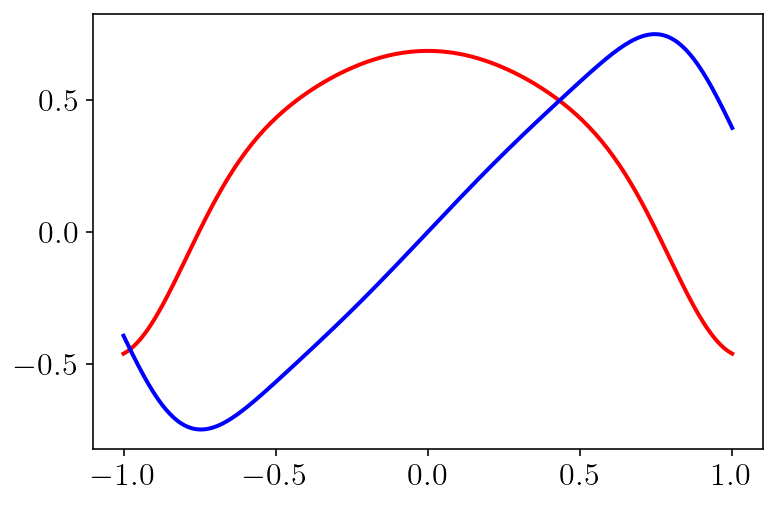

done after n_iterations=0 with n_panels=1


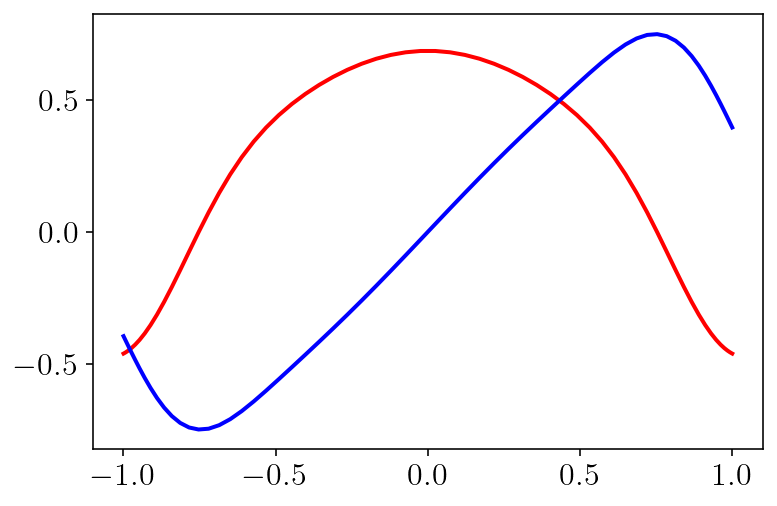

done after n_iterations=1 with n_panels=2


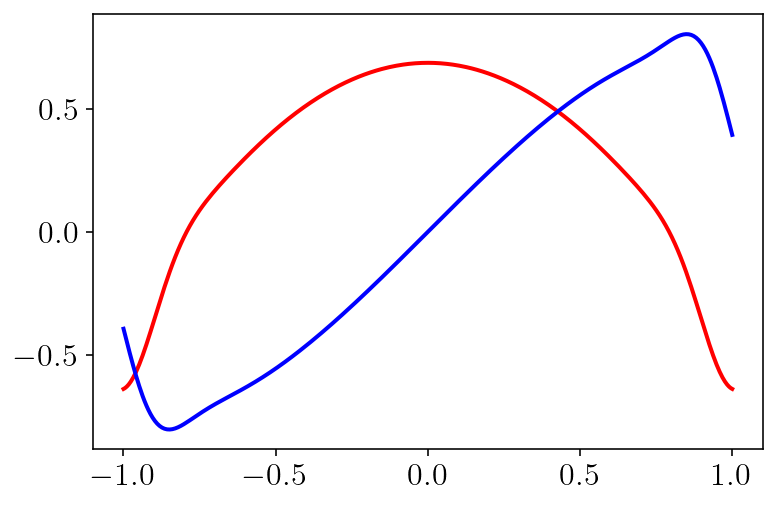

done after n_iterations=5 with n_panels=32


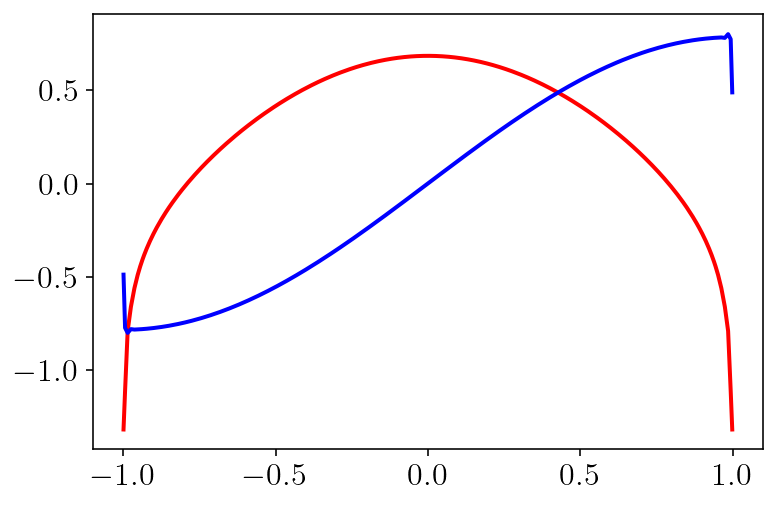

done after n_iterations=6 with n_panels=64


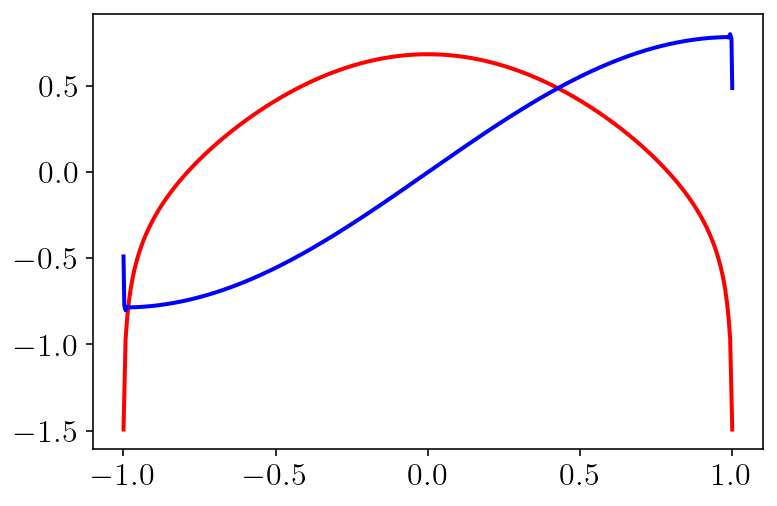

In [190]:
trial(*gauss_rule(256), 4.0, f)

trial(*gauss_rule(64), 4.0, f)

trial(*gauss_rule(128), 1.0, f)

trial(*gauss_rule(8), 1.0 / 8.0, f)

trial(*gauss_rule(8), 1.0 / 16.0, f)

In [231]:
def approach_test(obs_pts, slip):
    panel_width = 0.24
    nq = 16
    fault, = stage1_refine([(t, t * 0, t)], gauss_rule(nq), control_points=[(0, 0, 1.0, panel_width)])
    obs_pts.shape
    V1 = hypersingular_matrix(fault, obs_pts).dot(slip(fault.pts[:,1]))[:,0]

    panel_width = 0.12
    nq = 32
    fault, = stage1_refine([(t, t * 0, t)], gauss_rule(nq), control_points=[(0, 0, 1.0, panel_width)])
    obs_pts.shape
    V2 = hypersingular_matrix(fault, obs_pts).dot(slip(fault.pts[:,1]))[:,0]

#     plt.plot(fault.pts[:,1], slip(fault.pts[:,1]))
#     plt.show()
    
    return V1 - V2

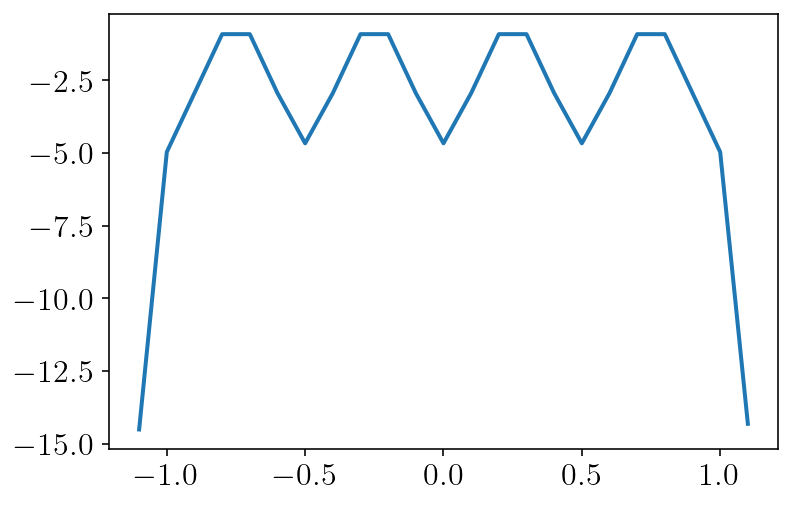

In [236]:

seq1 = []
yvs = np.linspace(-1.1, 1.1, 23)
for yv in yvs:
    dist = 2.0 ** -np.arange(10)
    obs_pts = np.stack((dist, np.full_like(dist, yv)), axis=1)
    #print(approach_test(obs_pts, lambda x: np.cos(x * np.pi * 0.5)))
    err = approach_test(obs_pts, lambda x: np.ones_like(x))
    seq1.append(err[6])
plt.plot(yvs, np.log10(np.abs(seq1)))
plt.show()

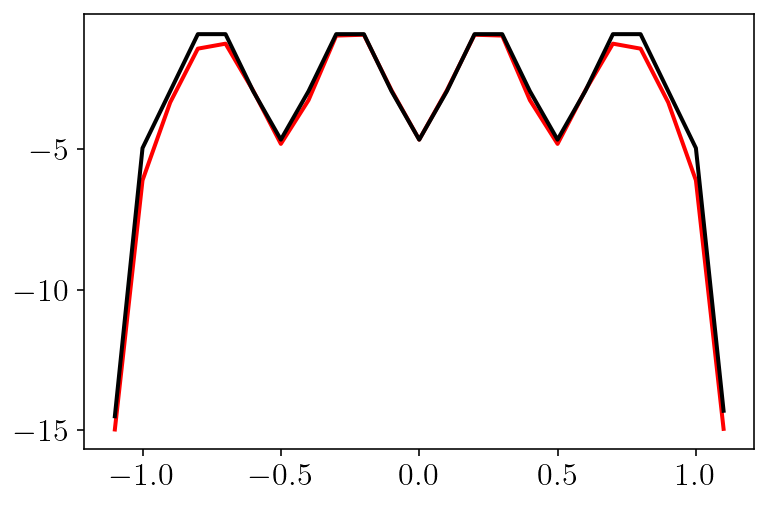

In [237]:
seq = []
yvs = np.linspace(-1.1, 1.1, 23)
for yv in yvs:
    dist = 2.0 ** -np.arange(10)
    obs_pts = np.stack((dist, np.full_like(dist, yv)), axis=1)
    #print(approach_test(obs_pts, lambda x: np.cos(x * np.pi * 0.5)))
    err = approach_test(obs_pts, lambda x: np.cos(x * np.pi * 0.5))
    seq.append(err[6])
plt.plot(yvs, np.log10(np.abs(seq)), 'r-')
plt.plot(yvs, np.log10(np.abs(seq1)), 'k-')
plt.show()